Here I'm going to test acoustic tracking with a single bat using a simple audio file with the POSIX stamp 1532807201

This is a 16 channel recording split over 2 Fireface UC's, with 8 channels each. All SANKEN's were on channels 9-12 (1-4 of the second device). 

### The max input level could be different across the SANKEN channels. 
2 channels were probably fed into the instrument in, and 2 channels were fed into the XLR. I need to be aware of this as in the Fireface802, the max input level is different when in the same input port the XLR and instrument line are used. 

For the Fireface UC, the first 2 channels when used as XLR has a max input of 10 dBu @0 dB gain, while when used with instrument has a max input of 21 dBu @0 dB gain. Channels 3-4 (as well as channels 5-8) with the instrument inputs has a max input level of 19 dBu @ 0 dB gain. 

While it may not make such a big difference for the acoustic tracking right now - it might become important later on. 

In [1]:
import batracker
import numpy as np 
import scipy.signal as signal 
import matplotlib.pyplot as plt 
import soundfile as sf
import glob

In [30]:
import batracker
from batracker.localisation import friedlander_1987 as fr87
from batracker.localisation import schau_robinson_1987 as sr87

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from batracker.signal_detection.detection import cross_channel_threshold_detector
from batracker.signal_detection.detection import envelope_detector
from batracker.tdoa_estimation.tdoa_estimators import measure_tdoa
from batracker.correspondence_matching.multichannel_match import generate_crosscor_boundaries

In [3]:
%matplotlib notebook

In [4]:
timestamp = '1532807201'
audio_folder= 'E://fieldwork_2018_002//actrackdata//wav//2018-07-28_001//'
audio_file =  glob.glob(audio_folder+'*'+timestamp+'.WAV')
audio_file

['E://fieldwork_2018_002//actrackdata//wav//2018-07-28_001\\MULTIWAV_2018-07-28_22-46-41_1532807201.WAV']

In [5]:
# get the first 1 second of the file:
fs = 192000
part_audio = sf.read(audio_file[0])[0][:fs]
# choose channels 9-12
part_tristar_channels = part_audio[:,[8,9,10,11]]

<IPython.core.display.Javascript object>


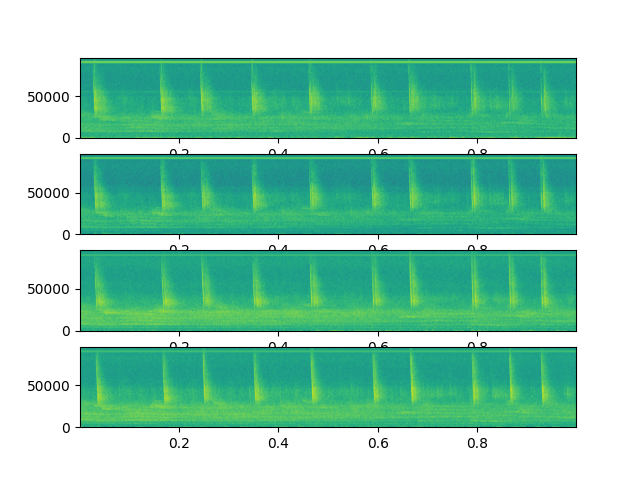

In [6]:
plt.figure()
a0 = plt.subplot(411)
for i in range(4):
    plotid = 411 +i
    if not plotid == 411:
        plt.subplot(plotid, sharex=a0)
    else:
        plt.subplot(plotid)
    plt.specgram(part_tristar_channels[:,i], Fs=fs, NFFT=256,noverlap=192)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 127.97it/s]

4 57600


<IPython.core.display.Javascript object>


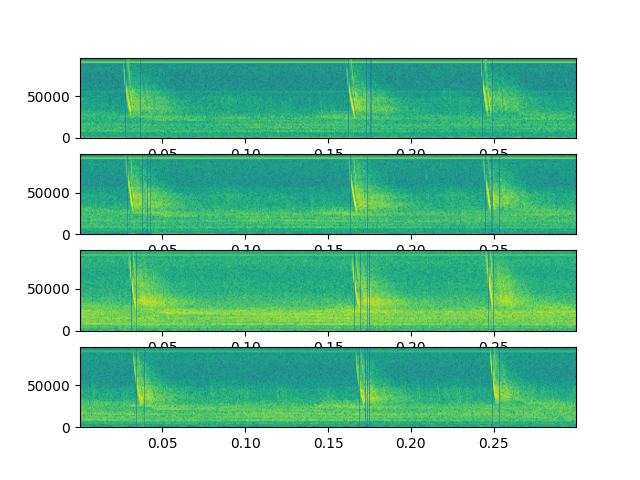

In [7]:
# code taken from the example in https://batracker.readthedocs.io/en/latest/prototyping/plot_start_to_end.html
audio = part_tristar_channels.copy()[:int(fs*0.3)] 
#detections = cross_channel_threshold_detector(audio, fs,
#                                              dbrms_window=2.5*10**-3,
#                                              dbrms_threshold=-47)

detections = cross_channel_threshold_detector(audio, fs,
                                              detector_function=envelope_detector,
                                              threshold_dbpeak=-46,
                                             lowpass_durn=0.0025)
                                              
# Spectrogram of the cross-corr boundaries
plt.figure()
ax= plt.subplot(411)
plt.specgram(audio[:,0], Fs=fs)
for each in detections[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(audio[:,i-1], Fs=fs)
    for each in detections[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)


In [8]:
# filter all detections, and keep only those that are >1 ms long.
min_durn = 0.002
filtered_detections = []
for channel_dets in detections:
    long_detections = []
    for detn in channel_dets:
        if detn[1]-detn[0]>=min_durn:
            long_detections.append(detn)
    filtered_detections.append(long_detections)
        

In [9]:
filtered_detections

[[(0.02734375, 0.036536458333333334),
  (0.16182291666666668, 0.17277083333333335),
  (0.24320833333333333, 0.24896875)],
 [(0.028890625, 0.03752083333333334),
  (0.163484375, 0.173265625),
  (0.24489583333333334, 0.24830208333333334),
  (0.24893229166666667, 0.25304166666666666)],
 [(0.031359375, 0.034140625),
  (0.16568229166666668, 0.16908333333333334),
  (0.2463125, 0.24928125)],
 [(0.034328125, 0.03880729166666667),
  (0.168828125, 0.17252604166666666),
  (0.248703125, 0.25297395833333336)]]

<IPython.core.display.Javascript object>


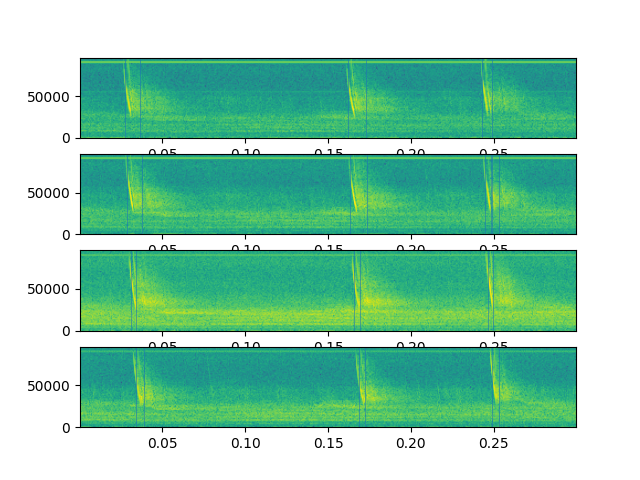

In [10]:
# Spectrogram of the cross-corr boundaries
plt.figure()
ax= plt.subplot(411)
plt.specgram(audio[:,0], Fs=fs)
for each in filtered_detections[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(audio[:,i-1], Fs=fs)
    for each in filtered_detections[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)

In [11]:
import copy

In [12]:
final_detections =  copy.deepcopy(filtered_detections)
# remove the last detection on channel 1
final_detections[1].pop()

(0.24893229166666667, 0.25304166666666666)

In [13]:
R = 1.2 # meters
theta = np.pi/3
mic_positions = np.array([[0,0,0],
                          [-R*np.sin(theta), 0, -R*np.cos(theta)],
                          [R*np.sin(theta),  0, -R*np.cos(theta), ],
                          [0,0,R]])

ag = pd.DataFrame(mic_positions)
ag.columns  = ['x','y','z']

In [14]:
crosscor_boundaries = generate_crosscor_boundaries(final_detections, ag)

num_channels = audio.shape[1]

In [16]:
reference_ch = 0

all_tdoas = {}
for i,each_common in enumerate(crosscor_boundaries):
    start, stop = each_common
    start_sample, stop_sample = int(start*fs), int(stop*fs)

    tdoas = measure_tdoa(audio[start_sample:stop_sample,:], fs, ref_channel=reference_ch)
    all_tdoas[i] = tdoas

In [19]:
all_tdoas

{0: array([0.00150781, 0.00327865, 0.00592448]),
 1: array([0.00151302, 0.00314844, 0.00561719]),
 2: array([0.00151042, 0.00303646, 0.00540625])}

In [21]:
vsound = 338.0
all_positions = []
num_rows = mic_positions.shape[0]-1
calculated_positions = np.zeros((3, 3))
for det_number, tdoas in all_tdoas.items():
    try:
        d = vsound*tdoas
        pos = fr87.solve_friedlander1987(mic_positions, d, j=reference_ch,
                                         use_analytical=False).flatten()
        calculated_positions[det_number,:] = pos
    except:
        print(f'COULD NOT CALCULATE POSITION FOR TEST POSITION {det_number}')

COULD NOT CALCULATE POSITION FOR TEST POSITION 0
COULD NOT CALCULATE POSITION FOR TEST POSITION 1
COULD NOT CALCULATE POSITION FOR TEST POSITION 2


In [37]:
d = vsound*tdoas
pos = fr87.solve_friedlander1987(mic_positions, d, j=reference_ch,
                                 use_analytical=False).flatten()

NotImplementedError: Friedlander 1987 algorithm not yet implemented for 4 channels! Please raise issue or submit a pull request:)!

In [27]:
dir(batracker.localisation)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'friedlander_1987']